In [11]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

merging the datasets to get the required information

In [43]:
expansion_df = pd.read_csv("expansion_outcome.csv")
product_df = pd.read_csv("product.csv")
feedback_df = pd.read_csv("customer_feedback.csv")
customer_df = pd.read_csv("customer.csv")
expansion_df["score_date"] = pd.to_datetime(expansion_df["score_date"], format='mixed', dayfirst=True)
product_df["score_date"] = pd.to_datetime(product_df["score_date"], format='mixed', dayfirst=True)
feedback_df["score_date"] = pd.to_datetime(feedback_df["score_date"], format='mixed', dayfirst=True)
customer_df["score_date"] = pd.to_datetime(customer_df["score_date"], format='mixed', dayfirst=True)
merged_df = expansion_df.merge(product_df, on=["id", "score_date"], how="inner")
merged_df = merged_df.merge(feedback_df, on=["id", "score_date"], how="left")
merged_df = merged_df.merge(customer_df, on=["id", "score_date"], how="left")
selected_columns = [
    "id", "score_date", "current_arr", "team_plus", "pro_plus", "ent_plus", 
    "csat_score", "num_low_sev_outages", "num_high_sev_outages", "num_tickets_deflected","customer_age_quarters",
    "product_counts", "crm_employee_range","region_emea", "region_apac", "region_amer","region_latam",
    "segment_smb","segment_non_smb","segment_commercial","segment_enterprise","segment_midmarket"
]
merged_df = merged_df[selected_columns]
merged_df.to_csv("final_merged_data.csv", index=False)
print("Merged dataset saved as final_merged_data.csv")


Merged dataset saved as final_merged_data.csv


creating new columns named cross-sale and upsale

In [33]:
merged_df = pd.read_csv("final_merged_data.csv")
merged_df.sort_values(by=["id", "score_date"], inplace=True)
merged_df["cross_sale"] = merged_df.groupby("id")["current_arr"].diff().gt(0).astype(int)
merged_df["up_sale"] = merged_df.groupby("id")["product_counts"].diff().gt(0).astype(int)
merged_df.to_csv("final_merged_data.csv", index=False)
print("cross_sale and up_sale columns added to final_merged_data.csv")

cross_sale and up_sale columns added to final_merged_data.csv


assumption-1: role of customer satisfaction in cross_sale and up_sale

C:\Users\PaidiVibhavanRao\AppData\Local\Temp\ipykernel_9884\1909015826.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="csat_score", y="cross_sale", data=csat_analysis, ax=axes[0], palette="Blues")
C:\Users\PaidiVibhavanRao\AppData\Local\Temp\ipykernel_9884\1909015826.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
C:\Users\PaidiVibhavanRao\AppData\Local\Temp\ipykernel_9884\1909015826.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="csat_score", y="up_sale", data=csat_analysis, ax=axes[1], palette="Greens")
C:\Users\PaidiVibhav

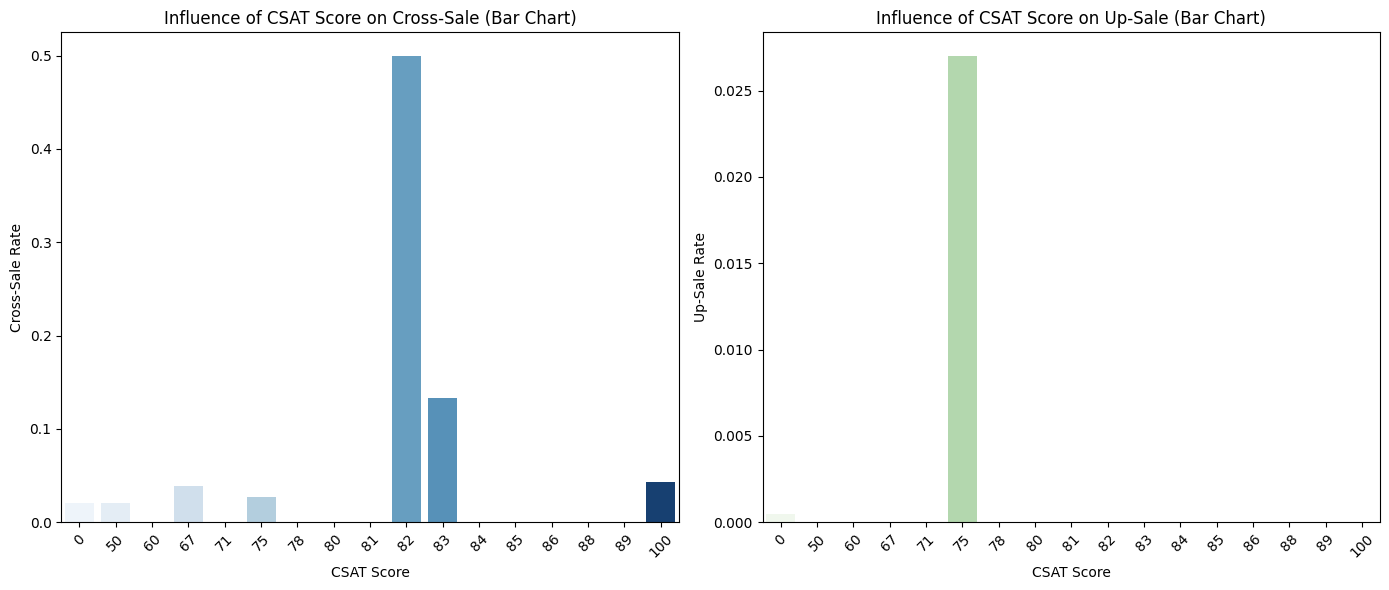

In [34]:
df = pd.read_csv("final_merged_data.csv")
df = df.dropna(subset=["csat_score", "cross_sale", "up_sale"])
csat_analysis = df.groupby("csat_score")[["cross_sale", "up_sale"]].mean().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x="csat_score", y="cross_sale", data=csat_analysis, ax=axes[0], palette="Blues")
axes[0].set_title("Influence of CSAT Score on Cross-Sale (Bar Chart)")
axes[0].set_xlabel("CSAT Score")
axes[0].set_ylabel("Cross-Sale Rate")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
sns.barplot(x="csat_score", y="up_sale", data=csat_analysis, ax=axes[1], palette="Greens")
axes[1].set_title("Influence of CSAT Score on Up-Sale (Bar Chart)")
axes[1].set_xlabel("CSAT Score")
axes[1].set_ylabel("Up-Sale Rate")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()


assumption-2: role of region in cross-sale and up-sale of products

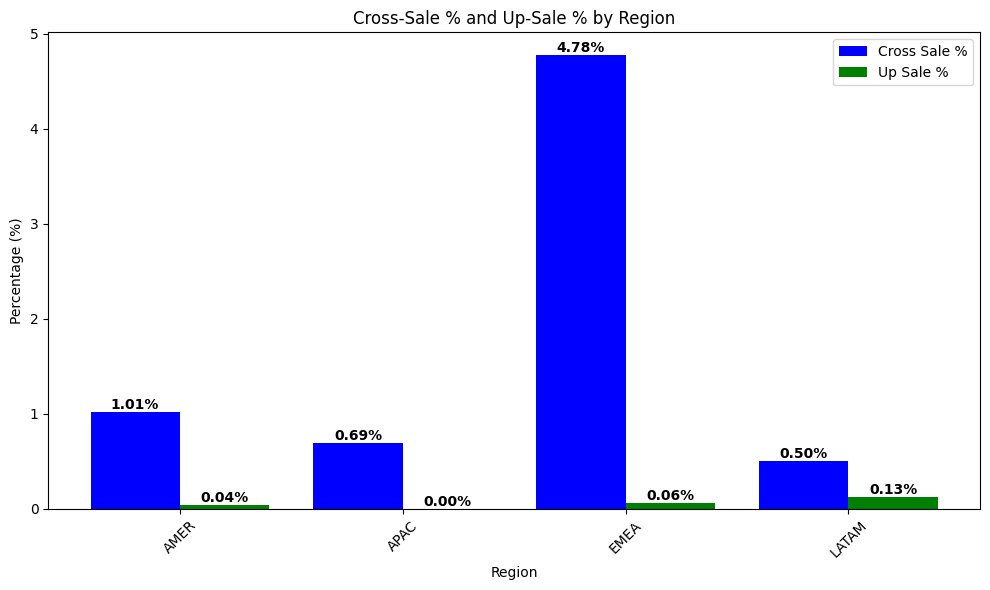

In [35]:
df = pd.read_csv("final_merged_data.csv")
region_columns = ["region_amer", "region_emea", "region_apac", "region_latam"]
def get_region(row):
    for region in region_columns:
        if row.get(region, 0) == 1:
            return region.replace("region_", "").upper()
    return "UNKNOWN"
df["region"] = df.apply(get_region, axis=1)
region_analysis = df.groupby("region").agg(
    cross_sale_yes=("cross_sale", lambda x: (x == 1).sum()),
    cross_sale_no=("cross_sale", lambda x: (x == 0).sum()),
    up_sale_yes=("up_sale", lambda x: (x == 1).sum()),
    up_sale_no=("up_sale", lambda x: (x == 0).sum())
).reset_index()
region_analysis["cross_sale_percent"] = (region_analysis["cross_sale_yes"] /
                                         (region_analysis["cross_sale_yes"] + region_analysis["cross_sale_no"])) * 100
region_analysis["up_sale_percent"] = (region_analysis["up_sale_yes"] /
                                      (region_analysis["up_sale_yes"] + region_analysis["up_sale_no"])) * 100
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(region_analysis["region"]))
width = 0.4
bars1 = ax.bar(x - width/2, region_analysis["cross_sale_percent"], width, color="blue", label="Cross Sale %")
bars2 = ax.bar(x + width/2, region_analysis["up_sale_percent"], width, color="green", label="Up Sale %")
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
ax.set_title("Cross-Sale % and Up-Sale % by Region")
ax.set_xlabel("Region")
ax.set_ylabel("Percentage (%)")
ax.set_xticks(x)
ax.set_xticklabels(region_analysis["region"], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

assumption:3 role of segments in cross_sale and up_sale of products


      segment  cross_sale_yes  cross_sale_no  up_sale_yes  up_sale_no
0  COMMERCIAL              37           1142            0        1179
1  ENTERPRISE              17            536            0         553
2   MIDMARKET              17            406            0         423
3     NON_SMB             165           8036            2        8199
4         SMB              89           2972            4        3057


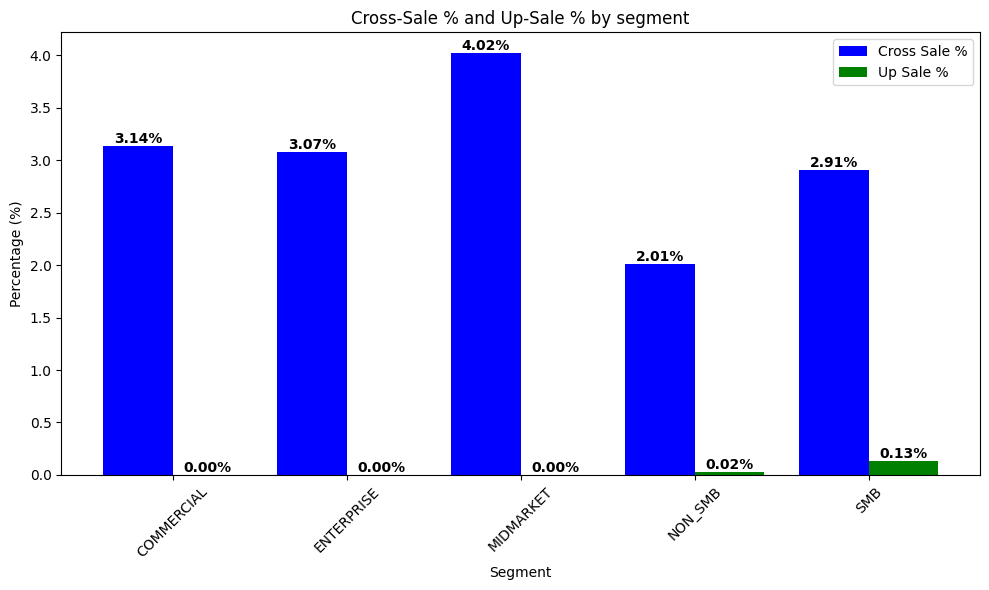

In [ ]:
df = pd.read_csv("final_merged_data.csv")
segment_columns = ["segment_commercial","segment_enterprise","segment_midmarket","segment_non_smb","segment_smb"]
def get_segment(row):
    for segment in segment_columns:
        if row.get(segment, 0) == 1:
            return segment.replace("segment_", "").upper()
    return "UNKNOWN"
df["segment"] = df.apply(get_segment, axis=1)
segment_analysis = df.groupby("segment").agg(
    cross_sale_yes=("cross_sale", lambda x: (x == 1).sum()),
    cross_sale_no=("cross_sale", lambda x: (x == 0).sum()),
    up_sale_yes=("up_sale", lambda x: (x == 1).sum()),
    up_sale_no=("up_sale", lambda x: (x == 0).sum())
).reset_index()
print(segment_analysis)
segment_analysis["cross_sale_percent"] = (segment_analysis["cross_sale_yes"] / (segment_analysis["cross_sale_yes"] + segment_analysis["cross_sale_no"])) * 100
segment_analysis["up_sale_percent"] = (segment_analysis["up_sale_yes"] / (segment_analysis["up_sale_yes"] + segment_analysis["up_sale_no"])) * 100
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(segment_analysis["segment"]))
width = 0.4
bars1 = ax.bar(x - width/2, segment_analysis["cross_sale_percent"], width, color="blue", label="Cross Sale %")
bars2 = ax.bar(x + width/2, segment_analysis["up_sale_percent"], width, color="green", label="Up Sale %")
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
ax.set_title("Cross-Sale % and Up-Sale % by segment")
ax.set_xlabel("Segment")
ax.set_ylabel("Percentage (%)")
ax.set_xticks(x)
ax.set_xticklabels(segment_analysis["segment"], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()-

assumption:4 role of customer_age_quarters in cross-sale and up-sale

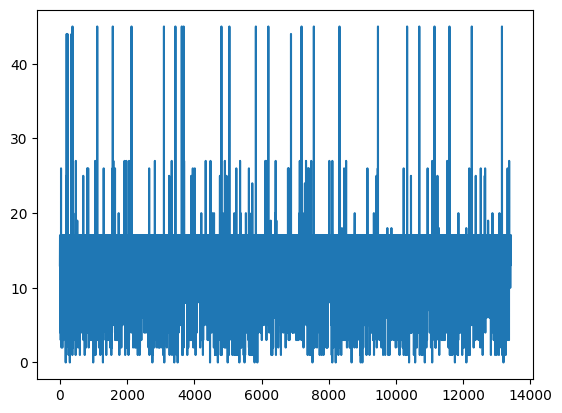

In [47]:
df = pd.read_csv("final_merged_data.csv")
plt.plot(df["customer_age_quarters"])
